In [1]:
import matplotlib
import seaborn
import pandas
import networkx
import tqdm
import gzip

from collections import Counter

%matplotlib inline

In [2]:
ecosystems = ['pypi', 'npm', 'cran']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}

In [3]:
graphs = {}

for ecos in ecosystems:
    with gzip.GzipFile('../../{}/data/packages.csv.gz'.format(ecos)) as f:
        packages = pandas.read_csv(f, index_col=[0,1])
    with gzip.GzipFile('../../{}/data/deps.csv.gz'.format(ecos)) as f:
        deps = pandas.read_csv(f)

    # Take latest version of each packages
    packages = packages.sort_values('time').groupby(level=0, sort=False).tail(1)
    deps = packages.merge(deps, how='inner', left_index=True, right_on=['package', 'version']).dropna()

    # Filter dependencies that are not registered packages
    deps = packages.reset_index().merge(deps, how='inner', left_on='package', right_on='dependency', suffixes=('_2', ''))
    
    # Construct graph
    graph = networkx.DiGraph()
    graph.add_nodes_from(packages.index.get_level_values('package'))
    edges = ((row.package, row.dependency) for row in deps[['package', 'dependency']].itertuples())
    graph.add_edges_from(edges)
    
    graphs[ecos] = graph

## Packages and Dependencies

In [4]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    data[ecos]['packages'] = graph.order()
    data[ecos]['dependencies'] = graph.size()
    data[ecos]['pkg_with_deps'] = len([n for n, d in graph.out_degree_iter() if d > 0])
    data[ecos]['pkg_with_rev_deps'] = len([n for n, d in graph.in_degree_iter() if d > 0])
    data[ecos]['pkg_non_isolated'] = len([True for n, d in graph.degree_iter() if d > 0])
    data[ecos]['pkg_isolated'] = len([True for n, d in graph.degree_iter() if d == 0])
df = pandas.DataFrame.from_dict(data, orient='index')
df

,dependencies,pkg_isolated,packages,pkg_non_isolated,pkg_with_rev_deps,pkg_with_deps
cran,3770,7119,9568,2449,872,1921
npm,725450,109796,317160,207364,66129,185228
pypi,9214,77349,82134,4785,1739,3344


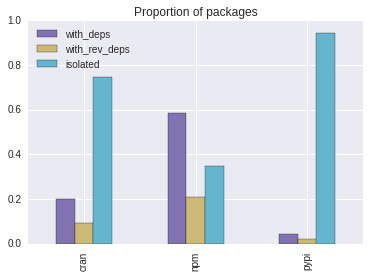

In [5]:
df['with_deps'] = df['pkg_with_deps'] / df['packages']
df['with_rev_deps'] = df['pkg_with_rev_deps'] / df['packages']
df['isolated'] = df['pkg_isolated'] / df['packages']
df[['with_deps', 'with_rev_deps', 'isolated']].plot.bar(title='Proportion of packages', color=seaborn.color_palette()[3:])

## Connected components

In [6]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    for component, size in Counter(len(component) for component in networkx.weakly_connected_components(graph)).items():
        data[ecos][component] = size
df = pandas.DataFrame.from_dict(data)
print('Number of (weakly) connected components by component size')
df.T.fillna(0)

Number of (weakly) connected components by component size


,1,2,3,4,5,6,7,8,9,10,...,27,28,32,35,36,41,106,2126,4349,201593
cran,7119.0,76.0,30.0,8.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
npm,109810.0,1486.0,296.0,119.0,40.0,32.0,9.0,11.0,11.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
pypi,77349.0,140.0,17.0,4.0,3.0,3.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


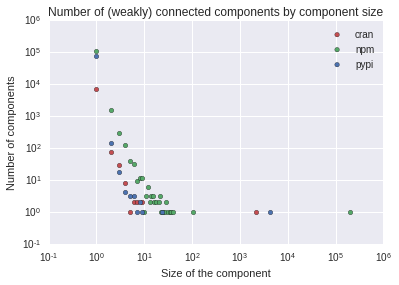

In [7]:
d = df.reset_index().rename(columns={'index': 'component'})
d = pandas.melt(d, id_vars='component', value_vars=['cran', 'npm', 'pypi'], var_name='ecosystem', value_name='size').dropna()

ax = None
for i, ecos in enumerate(graphs.keys()):
    kwargs = {
        'x': 'component', 
        'y': 'size',
        'label': ecos,
        'logx': True,
        'logy': True,
        'color': COLORS[ecos]
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = d.query('ecosystem == "{}"'.format(ecos)).plot.scatter(**kwargs)
ax.set_xlabel('Size of the component')
ax.set_ylabel('Number of components')
ax.set_title('Number of (weakly) connected components by component size')

## Hubs and Authorities

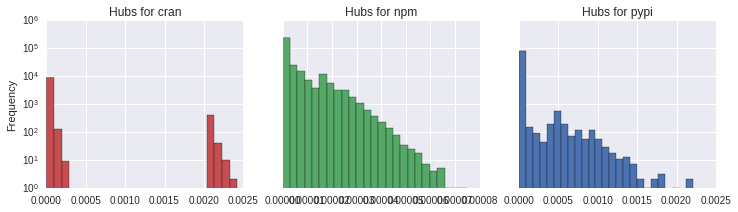

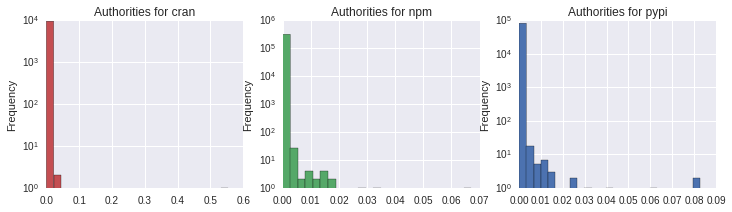

In [8]:
fig_hubs, ax_hubs = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_hubs.set_size_inches((12, 3))

fig_auth, ax_authorities = matplotlib.pyplot.subplots(ncols=3)
fig_auth.set_size_inches((12, 3))

for i, (ecos, graph) in enumerate(graphs.items()):
    hubs, authorities = networkx.hits_scipy(graph)
    hubs, authorities = pandas.Series(hubs), pandas.Series(authorities)
    hubs.plot.hist(label=ecos, ax=ax_hubs[i], bins=25, logy=True, color=COLORS[ecos])
    authorities.plot.hist(label=ecos, ax=ax_authorities[i], bins=25, logy=True, color=COLORS[ecos])
    ax_hubs[i].set_title('Hubs for {}'.format(ecos))
    ax_authorities[i].set_title('Authorities for {}'.format(ecos))

## Pagerank

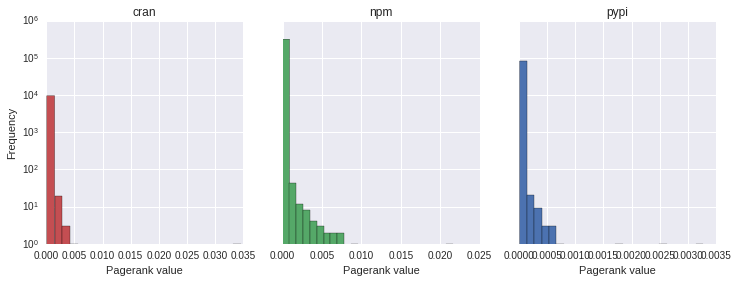

In [9]:
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig.set_size_inches((12, 4))

for i, (ecos, graph) in enumerate(graphs.items()):
    pagerank = networkx.pagerank(graph)
    pandas.Series(pagerank).plot.hist(label=ecos, ax=axes[i], bins=25, logy=True, color=COLORS[ecos])
    axes[i].set_title(ecos)
    axes[i].set_xlabel('Pagerank value')